In [129]:
import skimage.transform

import numpy as np
from matplotlib import pyplot as plt
from math import exp
from tqdm import tqdm_notebook as tqdm

plt.set_cmap('terrain');

<Figure size 432x288 with 0 Axes>

In [192]:
class terrain(object):
    def __init__(self,seed=42):
        '''self.img is the main terrain'''
        self.img = np.zeros((2,3),dtype=np.float)
        self.rand = np.random.RandomState(seed=seed)
        
    def genV1(self,imax=15,smallness=0.75,scale=1.5,maxsize=10**7):
        '''generates map that with large features first then smaller features
        This is done by adding normal noise and enlarging the array'''
        
        outsize = self.img.shape[0]*self.img.shape[1]*scale**(2*(imax-1))
        assert maxsize>outsize, 'Potential Memory error: Size = 6*scale**(2*(imax-1)) = {} is above maxsize = {}'.format(outsize,maxsize)
        
        J = smallness
        for i in range(imax):
            self.img += self.rand.normal(scale=J**i,size=self.img.shape) #add noise with amplitude J**i (J<1 thus smaller for large i)
            if i==imax-1:
                break
            self.img = skimage.transform.rescale(self.img,scale,anti_aliasing=False,mode='reflect',multichannel=False)
    
    def addseasnow(self,img,seafrac=0.5,snowfrac=0.05):
        '''adds snow and sea by clipping the self.img terrain array
        This work because the color map terrain: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        has blue at the lowest value and white at the highest value'''
        pmin = np.percentile(img,seafrac*100)
        pmax = np.percentile(img,(1-snowfrac)*100)
        img = np.clip(img,pmin,pmax) #make snow and sea
        return img
    
    def addbeach(self,img,vmin=0.15,vmax=0.25):
        '''adds beach
        This work because the color map terrain: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        has sand colour at the middle value'''
        Amin,Amax = np.min(img),np.max(img)
        img2 = (img-Amin)/(Amax-Amin) #rescale 0<=img2<=1
        img[(img2>vmin)*(img2<vmax)] = (Amax+Amin)/2 #set shoreline
        return img
    
    def plot(self,raw=False):
        '''simple plotter, uses terrain colour map: https://matplotlib.org/users/colormaps.html'''
        img = np.copy(self.img)
        if not raw:
            img = self.addseasnow(img)
            img = self.addbeach(img)
        plt.figure(figsize=(15,12))
        plt.imshow(img,cmap='terrain')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    


$$ \Delta t = \frac{L}{|v| + \epsilon}$$
$$x' = x + v \Delta t$$
$$v' = (-g \nabla h(x) - \gamma v) \Delta t + v$$
$$c' =\frac{e^{-\frac{\text{$\Delta $t}}{\tau }} \left(\text{c0} \text{$\Delta $t}+c_m'
   \left(e^{\text{$\Delta $t}/\tau } (\text{$\Delta $t}-\tau )+\tau \right)-c_m
   \left(-\tau  e^{\text{$\Delta $t}/\tau }+\text{$\Delta $t}+\tau
   \right)\right)}{\text{$\Delta $t}}$$


In [193]:
def partical_setiment(h,x0,v0,L=1/2,dtmax=10,gamma=0.05,cmax = lambda v: np.sum(v**2)**0.5,tauc=1,g=1,cpickup=0.01):
    #init partical
    x = np.array(x0)
    v = np.array(v0)
    c = 0

    #init hist
    xhist = [x]
    thist = [0]
    vhist = [v]
    chist = [c]

    #loop
    DX = DY = 1
    imax = 1000
    for i in range(imax):
        xm,xp = int(x[0])%h.shape[1],(int(x[0])+1)%h.shape[1]
        ym,yp = int(x[1])%h.shape[0],(int(x[1])+1)%h.shape[0]
        gx = ((h[ym,xp]-h[ym,xm])/DX + (h[yp,xp]-h[yp,xm])/DX)/2
        gy = ((h[yp,xm]-h[ym,xm])/DY + (h[yp,xp]-h[ym,xp])/DY)/2
    #     print(xm,xp,ym,yp,gx,gy)
        a = (-g*np.array([gx,gy])-gamma*v)

        vabs,aabs = np.sum(v**2)**0.5,np.sum(a**2)**0.5
        dtvel = (-vabs + (vabs**2+2*aabs*L)**0.5)/aabs if aabs>1e-20 else L/vabs
        dtdrag = 1/gamma/3
        dt = min(dtvel,dtdrag,dtmax)
    #     dt = 0.001
        xnew = x + v*dt
        vnew = v + a*dt

        cnew = exp(-dt/tauc)/dt*(c*dt+
             cmax(np.sum(vnew**2)**0.5)*(exp(dt/tauc)*(dt-tauc)+tauc)-
             cmax(np.sum(v**2)**0.5)*(-tauc*exp(dt/tauc)+dt+tauc))
        
        if i==imax-1 or (i%100==0 and len(xhist)>100 and sum(np.std(xhist[-100:],axis=0))<5):
            breaknow=True
            cnew = 0
        else:
            breaknow = False
        
        dc = cnew-c
        x,v,c = xnew,vnew,cnew
    #     print('x',x,'v',v,'dt',dt)
        xhist.append(x)
        vhist.append(v)
        thist.append(thist[-1]+dt)
        chist.append(c)
        
        h[ym,xm] -= dc*cpickup/4 #how to do this
        h[ym,xp] -= dc*cpickup/4
        h[yp,xm] -= dc*cpickup/4
        h[yp,xp] -= dc*cpickup/4

        if breaknow: 
            break
    xhist = np.array(xhist)
    thist = np.array(thist)
    vhist = np.array(vhist)
    chist = np.array(chist)
    return thist,xhist,vhist,chist

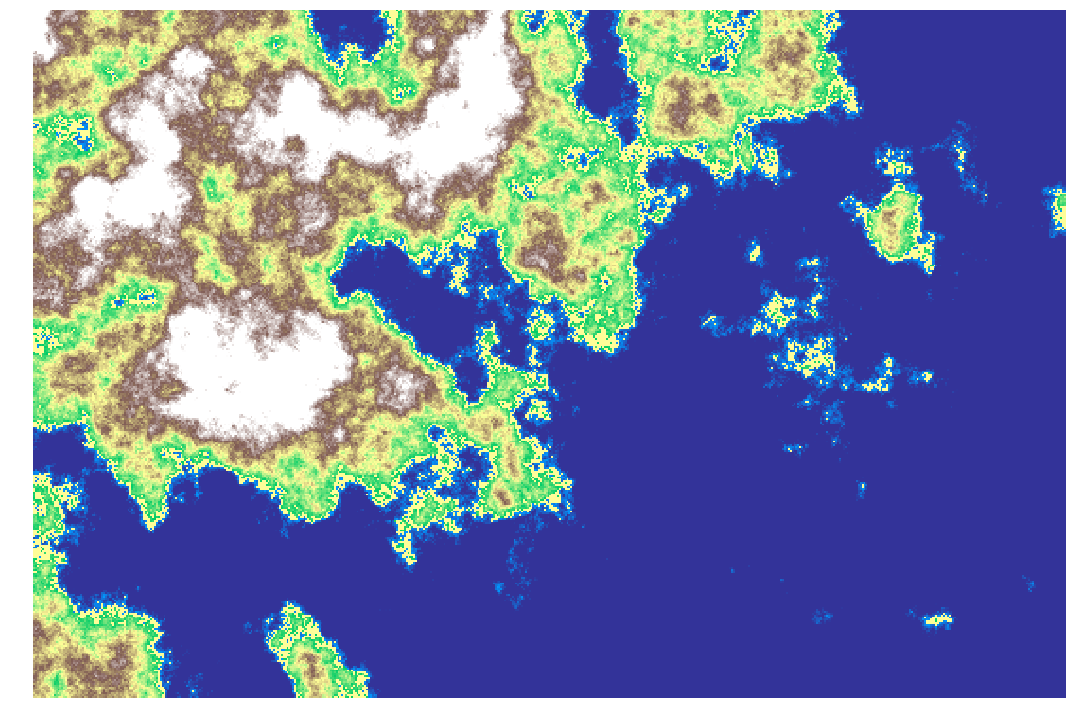

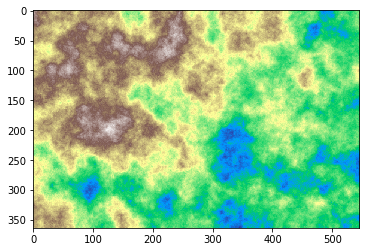

In [201]:
ter = terrain()
ter.genV1(imax=14)
ter.plot()
plt.imshow(ter.img)
plt.show()

In [195]:


#make terran
if False:
    xgrid,ygrid = np.arange(50),np.arange(50)
    Xgrid,Ygrid = np.meshgrid(xgrid,ygrid)
    h = np.array((Xgrid-25)**2+(Ygrid-25)**2,dtype=float)
else:
    h = ter.img
h = np.copy(h)
h -= np.mean(h)
h /= np.std(h)*(2*g)
h0 = np.copy(h)
hy,hx = h.shape

#partical dynamics
# L = 2/3
# dtmax = 10
# gamma = 0.05
# cmax = 
# tauc = 1
# g = 1
# cpickup = 0.01


In [196]:
for k in tqdm(range(1000)):
    x0 = [np.random.randint(0,hx),np.random.randint(0,hy)]
    hcur = max(h[x0[1],x0[0]],h[(x0[1]+1)%hy,x0[0]],h[x0[1],(x0[0]+1)%hx],h[(x0[1]+1)%hy,(x0[0]+1)%hx])
    hmax = np.max(h)
    vmax = ((hmax-hcur)*2)**0.5/2
    v = np.random.uniform(0,vmax)
    th = np.random.uniform(0,np.pi*2)
    v0 = [np.sin(th)*v,np.cos(th)*v]
    thist,xhist,vhist,chist = partical_setiment(h,x0,v0,gamma=0.1)
    np.sum(abs(h-h0))

In [197]:
np.sum(h)

1.1368683772161603e-13

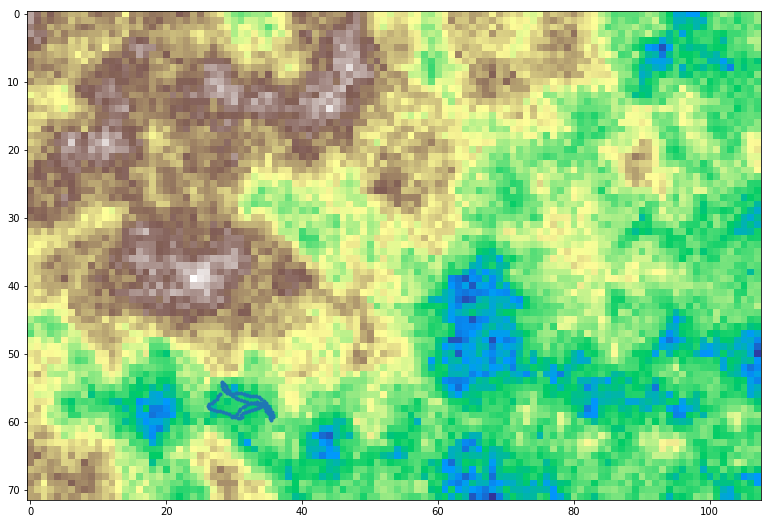

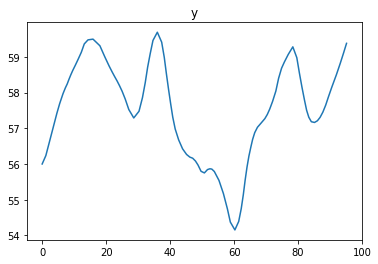

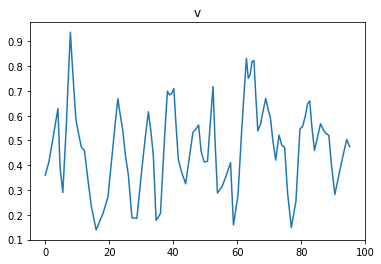

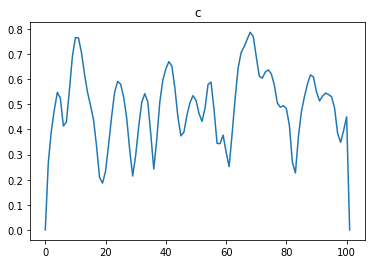

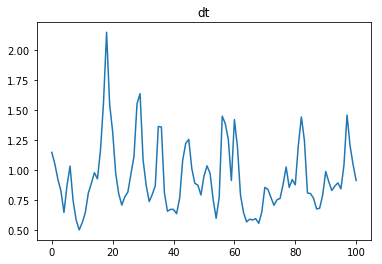

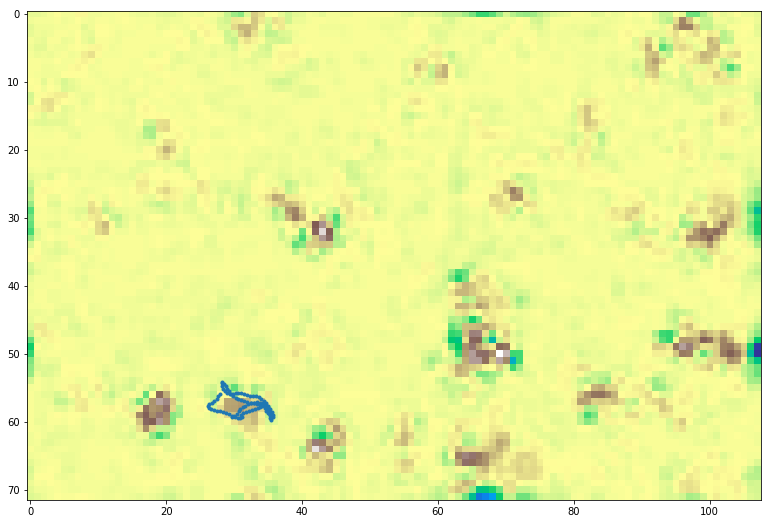

In [198]:
plt.figure(figsize=(16,9))
plt.imshow(h)
xhist = np.array(xhist)
plt.plot(xhist[:,0]%h.shape[1],xhist[:,1]%h.shape[0],'.')
plt.show()



plt.title('y')
plt.plot(thist,xhist[:,1])
plt.show()
plt.title('v')
plt.plot(thist,np.sum(vhist**2,axis=1)**0.5)
plt.show()
plt.title('c')
plt.plot(chist)
plt.show()
plt.title('dt')
plt.plot(thist[1:]-thist[:-1])
plt.show()
plt.figure(figsize=(16,9))
plt.imshow(h-h0)
xhist = np.array(xhist)
plt.plot(xhist[:,0]%h.shape[1],xhist[:,1]%h.shape[0],'.')
plt.show()

In [136]:
abs(h-h0)

array([[2.90610335e+00, 3.25789029e+00, 1.87090757e-01, ...,
        1.30321722e-02, 6.65020168e-02, 1.67273224e-02],
       [3.51825623e+00, 4.21988043e+00, 7.05565147e-01, ...,
        1.59936411e-02, 5.18140342e-02, 1.14497733e-01],
       [6.73000594e-01, 1.05632615e+00, 5.35900461e-01, ...,
        1.16221040e-02, 1.54767801e-02, 8.40333977e-02],
       ...,
       [6.77026340e-03, 1.83375407e-02, 1.35951703e-02, ...,
        2.33573671e-02, 2.01018670e-02, 7.91804094e-03],
       [2.44249274e-02, 3.17692256e-03, 1.04777223e-03, ...,
        1.62749652e-02, 6.75070960e-03, 2.55002188e-02],
       [4.11037904e-02, 7.87128097e-03, 3.45175432e-03, ...,
        1.25060481e-03, 2.94623937e-02, 7.09073754e-02]])

In [9]:
np.std(xhist[-100:],axis=0)

array([0.36424989, 0.3359049 ])

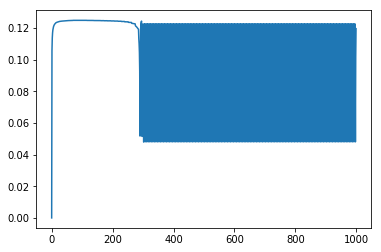

In [148]:
plt.plot(np.sum((xhist[:-1,:]-xhist[1:,:])**2,axis=1)**0.5 )